# Implementation of Fraud Detection model

The aim of this notebook is to implement fraud detection model using random forest classifier, hence detect any possible fraudulent transactions in the entire dataset.

This is going to be done in the following steps:

1. Read in and prepare the data

2. Tune the hyperparameters of the random forest classifiers

3. Train and test the validity of the models

4. Use those models to make predictions on the entire transaction datasets (whether or not the transaction is fradulent)

5. Calculate *reliability* of each merchant, and their consumer base

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from scipy.sparse import hstack
import plotly.graph_objects as go
import matplotlib.pyplot as plt

FRAUD_THRESHOLD = 50
TUNE_PARAMETERS = True
categorical_features = ['order_datetime', 'state', 'gender', 'merchant_revenue_lvl']

### Set up functions for the model

In [2]:
def encode_data(data):
    """
    This function encodes all categorical features and returns the concatenated dataframe.
    Arguments:
    data: filtered, transformed and encoded dataset in the form of pd dataframe.
    """
    y = data['is_fraud']
    data = data.drop(['is_fraud'], axis=1)
    
    categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = data.select_dtypes(exclude=['object']).columns.tolist()
    
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True, min_frequency=2, drop='first')
    encoded_categorical = encoder.fit_transform(data[categorical_cols])
    
    # Keep the numerical features
    numerical_data = data[numerical_cols].values

    # Initialize and fit the StandardScaler on the training data for the numerical features
    scaler = StandardScaler()
    scaler.fit(numerical_data)

    # Transform the numerical features for both training and test datasets
    scaled_numerical = scaler.transform(numerical_data)

    # Concatenate the encoded categorical features and numerical features for both datasets
    X_encoded = hstack([encoded_categorical, scaled_numerical])

    return (X_encoded, y)


In [3]:
def train_rfc(X, y, name, n=100):
    """
    This function trains the Random Forest classifier model on the dataset, 
    prints out the cross evaluation metrics and prints the classification report. 

    Arguments:
    X, y: filtered, transformed and encoded dataset in the form of pd dataframe.
    name: 'consumer' or 'merchant'. A string that helps differentiate between 
            the two datasets
    n: parameter value for n_estimators
    """
    
    clf = Pipeline([('rfc', RandomForestClassifier(n_estimators=n))])


    # Calculate evaluation metrics for the cross validation
    accuracy = np.round(np.mean(cross_val_score(clf, X, y, scoring='accuracy')), 4)
    precision = np.round(np.mean(cross_val_score(clf, X, y, scoring='precision_macro')), 4)
    recall = np.round(np.mean(cross_val_score(clf, X, y, scoring='recall_macro')), 4)
    f1 = np.round(np.mean(cross_val_score(clf, X, y, scoring='f1_macro')), 4)

    print(f'Cross validation metrics for {name}')
    print(f'avg accuracy: {accuracy}')
    print(f'avg precision: {precision}')
    print(f'avg recall: {recall}')
    print(f'avg f1 score: {f1}')

    # Train and test the model for visualization purposes
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


    clf = Pipeline([('rfc', RandomForestClassifier(n_estimators=n))])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(classification_report(y_test, y_pred))

In [4]:
def preprocess_test(train_data, test_data):
    """
    This function performs encoding and standardizing for the test data
    """
    
    categorical_cols = train_data.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = train_data.select_dtypes(exclude=['object']).columns.tolist()
    
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True, min_frequency=2, drop='first')
    encoder.fit(train_data[categorical_cols])
    # Transform the categorical features in both the training and test datasets
    encoded_categorical_train = encoder.transform(train_data[categorical_cols])
    encoded_categorical_test = encoder.transform(test_data[categorical_cols])
    
    # Keep the numerical features
    numerical_train = train_data[numerical_cols].values
    numerical_test = test_data[numerical_cols].values

    # Initialize and fit the StandardScaler on the training data for the numerical features
    scaler = StandardScaler()
    scaler.fit(numerical_train)

    # Transform the numerical features for both training and test datasets
    scaled_numerical_train = scaler.transform(numerical_train)
    scaled_numerical_test = scaler.transform(numerical_test)

    # Concatenate the encoded categorical features and numerical features for both datasets
    X_train_encoded = hstack([encoded_categorical_train, scaled_numerical_train])
    X_test_encoded = hstack([encoded_categorical_test, scaled_numerical_test])

    return (X_train_encoded, X_test_encoded)

In [5]:
def predict_rfc(X_train, y_train, X_test, name, n=100):
    """
    This function trains Random Forest Classifier and returns the predicted labels
    for the test data.
    Arguments:
    X_train, y_train: filtered, transformed and encoded dataset in the form 
            of pd dataframe.
    X_test: filtered, transformed and encoded test dataset in the form of pd
            dataframe
    name: 'consumer' or 'merchant'. A string that helps differentiate between 
            the two datasets
    n: parameter value for n_estimators
    """

    clf = Pipeline([('rfc', RandomForestClassifier(n_estimators=n))])

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    col_name = name + '_is_fraud'
    y_pred = pd.DataFrame(y_pred, columns=[col_name])
    return y_pred

## 1. Prepare datasets

### Read in the data

In [6]:
data = pd.read_parquet('../data/raw/fraud_data')
print(data.shape)

(75272, 15)


In [7]:
consumer_data = data[data['consumer_fraud_prob'].notnull()]
merchant_data = data[data['merchant_fraud_prob'].notnull()]

### Apply Tranformations
1. Create a feature called is_fraud that equals True when the fraud probability is greater than the threshold (50%).
2. Take natural logarithm of the feature dollar_value to account for skewness in the distribution.

In [8]:
# Add a label is_fraud using the threshold value set above
consumer_data['is_fraud'] = consumer_data['consumer_fraud_prob'] \
    .apply(lambda x: True if float(x) >= FRAUD_THRESHOLD else False)
merchant_data['is_fraud'] = merchant_data['merchant_fraud_prob'] \
    .apply(lambda x: True if float(x) >= FRAUD_THRESHOLD else False)

consumer_data.drop(['consumer_fraud_prob', 'merchant_fraud_prob', 'year', 'month'], axis=1, inplace=True)
merchant_data.drop(['consumer_fraud_prob', 'merchant_fraud_prob', 'year', 'month'], axis=1, inplace=True)

# Take log(dollar_value)
consumer_data['dollar_value'] = consumer_data['dollar_value'].apply(lambda x: np.log(x))
merchant_data['dollar_value'] = merchant_data['dollar_value'].apply(lambda x: np.log(x))

/var/folders/np/m1q4q1w54q59sj70tvylvg5m0000gn/T/ipykernel_2959/3195162662.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consumer_data['is_fraud'] = consumer_data['consumer_fraud_prob'] \
/var/folders/np/m1q4q1w54q59sj70tvylvg5m0000gn/T/ipykernel_2959/3195162662.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merchant_data['is_fraud'] = merchant_data['merchant_fraud_prob'] \
/var/folders/np/m1q4q1w54q59sj70tvylvg5m0000gn/T/ipykernel_2959/3195162662.py:7: SettingWithCopyWarning: 
A value is trying 

In [9]:
# features used to train consumer fraud detection model
print(consumer_data.shape)
consumer_data.columns

(71633, 12)


Index(['state', 'gender', 'order_datetime', 'dollar_value',
       'merchant_revenue_lvl', 'merchant_take_rate', 'popDensity2022',
       'num_earners', 'medianAge_earners', 'median_income', 'population',
       'is_fraud'],
      dtype='object')

In [10]:
# features used to train merchant fraud detection model (same as above)
print(merchant_data.shape)
merchant_data.columns

(4003, 12)


Index(['state', 'gender', 'order_datetime', 'dollar_value',
       'merchant_revenue_lvl', 'merchant_take_rate', 'popDensity2022',
       'num_earners', 'medianAge_earners', 'median_income', 'population',
       'is_fraud'],
      dtype='object')

### Encode the training data

In [11]:
consumer_encoded, consumer_y = encode_data(consumer_data)
merchant_encoded, merchant_y = encode_data(merchant_data)
print(consumer_encoded.shape)
print(merchant_encoded.shape)

(71633, 384)
(4003, 66)


## 2. Tuning the hyperparameters

In [14]:
rfc_pipeline = Pipeline([('rfc', RandomForestClassifier())])
rfc_param_grid = {'rfc__n_estimators': [50, 100, 150, 200, 250]}

X_consumer = consumer_encoded
y_consumer = consumer_y

X_merchant = merchant_encoded
y_merchant = merchant_y

if TUNE_PARAMETERS:
    # Tuning for consumer dataset
    gs = GridSearchCV(rfc_pipeline,
                  param_grid=rfc_param_grid,
                  scoring='precision',
                  cv=4,
                  n_jobs=-1,
                  verbose=1)
    gs.fit(X_consumer, y_consumer)
    best_params = gs.best_params_
    print('Best Parameter for consumer dataset:', best_params)

    # Tuning for merchant dataset
    gs = GridSearchCV(rfc_pipeline,
                  param_grid=rfc_param_grid,
                  scoring='precision',
                  cv=4,
                  n_jobs=-1,
                  verbose=1)
    gs.fit(X_merchant, y_merchant)
    best_params = gs.best_params_
    print('Best Parameter for merchant dataset:', best_params)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


Best Parameter for consumer dataset: {'rfc__n_estimators': 250}
Fitting 4 folds for each of 5 candidates, totalling 20 fits
Best Parameter for merchant dataset: {'rfc__n_estimators': 150}


## 3. Train and test the Random Forest Classifier Model

Cross validation metrics for consumer
avg accuracy: 0.9866
avg precision: 0.843
avg recall: 0.5976
avg f1 score: 0.6457
              precision    recall  f1-score   support

       False       0.99      1.00      0.99     28218
        True       0.73      0.25      0.38       436

    accuracy                           0.99     28654
   macro avg       0.86      0.63      0.69     28654
weighted avg       0.98      0.99      0.98     28654



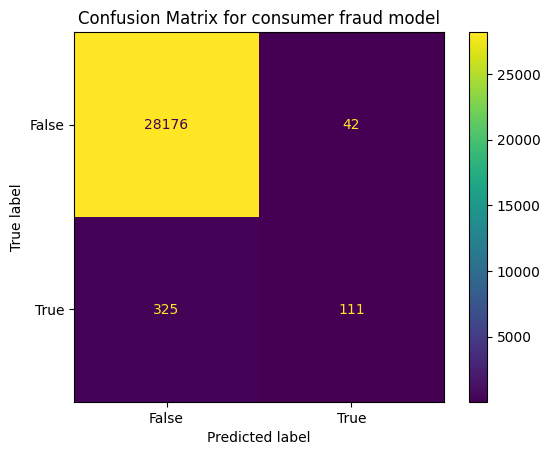

In [12]:
train_rfc(consumer_encoded, consumer_y, 'consumer', n=250)

Cross validation metrics for merchant
avg accuracy: 0.9915
avg precision: 0.9744
avg recall: 0.7909
avg f1 score: 0.8577
              precision    recall  f1-score   support

       False       0.99      1.00      1.00      1578
        True       0.80      0.50      0.62        24

    accuracy                           0.99      1602
   macro avg       0.90      0.75      0.81      1602
weighted avg       0.99      0.99      0.99      1602



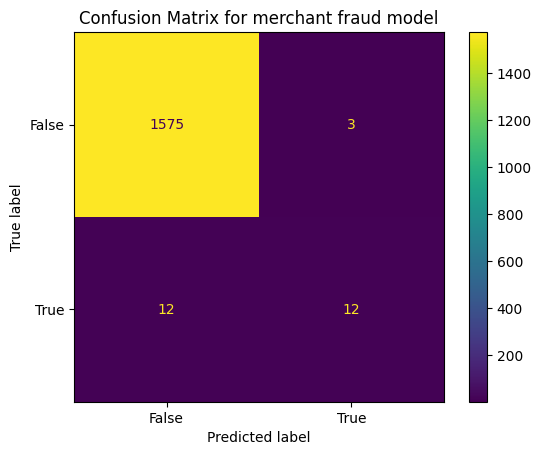

In [13]:
train_rfc(merchant_encoded, merchant_y, 'merchant', n=150)

Since we don't want to miss out on non-fraudulent transactions by labelling them incorrectly, we are maximizing the precision. 

## 4. Make prediction on the whole transaction dataset

In [14]:
full_data = pd.read_parquet('../data/raw/transactions_clean')
# Keep the order_id separate as we need this to join it back to the
# transactions dataset
full_data_key = full_data['order_id']

# Make sure that the columns match between train and test data
X_test = full_data.drop(['merchant_abn', 'order_id', 'consumer_id', 'postcode', 
                         'sum_income', 'merchant_name', 'merchant_desc', 
                         'consumer_fraud_prob', 'merchant_fraud_prob', 'year', 
                         'month'], axis=1)

In [15]:
X_test['dollar_value'] = X_test['dollar_value'].apply(lambda x: np.log(x))

### Train and predict the consumer fraud data

In [16]:
# Preprocess the consumer dataset
X_train_c = consumer_data.drop(['is_fraud'], axis=1)
y_train_c = consumer_data['is_fraud']
X_train_encoded_c, X_test_encoded_c = preprocess_test(X_train_c, X_test)

/opt/homebrew/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [17]:
# Predict the labels for consumer data
y_pred_c = predict_rfc(X_train_encoded_c, y_train_c, X_test_encoded_c, 'consumer', n=250)

sus_count_c = (y_pred_c['consumer_is_fraud'] == True).sum()
print(f'{sus_count_c} instances labelled as suspicious according to the consumer fraud model.')
print(f'{y_pred_c.shape[0]-sus_count_c} instances labelled as not suspicious according to the consumer fraud model.')
print(f'Proportion of fraudulent data: {np.round(100*sus_count_c/(y_pred_c.shape[0]), 2)}%')


3209 instances labelled as suspicious according to the consumer fraud model.
13610452 instances labelled as not suspicious according to the consumer fraud model.
Proportion of fraudulent data: 0.02%


### Train and predict the merchant fraud data

In [18]:
# Preprocess the merchant dataset
X_train_m = merchant_data.drop(['is_fraud'], axis=1)
y_train_m = merchant_data['is_fraud']
X_train_encoded_m, X_test_encoded_m = preprocess_test(X_train_m, X_test)

/opt/homebrew/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [19]:
# Predict the labels for the merchant data
y_pred_m = predict_rfc(X_train_encoded_m, y_train_m, X_test_encoded_m, 'merchant', n=150)

sus_count_m = (y_pred_m['merchant_is_fraud'] == True).sum()
print(f'{sus_count_m} instances labelled as suspicious according to the consumer fraud model.')
print(f'{y_pred_m.shape[0]-sus_count_m} instances labelled as not suspicious according to the consumer fraud model.')
print(f'Proportion of fraudulent data: {np.round(100*sus_count_m/(y_pred_m.shape[0]), 2)}%')


510611 instances labelled as suspicious according to the consumer fraud model.
13103050 instances labelled as not suspicious according to the consumer fraud model.
Proportion of fraudulent data: 3.75%


### Join the label with transactions dataset

In [20]:
result_with_key = pd.concat([full_data_key, y_pred_c, y_pred_m], 
                            axis=1, ignore_index=True)
result_with_key.columns= ['order_id', 'consumer_is_fraud', 'merchant_is_fraud']
print(result_with_key.shape)
result_with_key.head(10)

(13613661, 3)


,order_id,consumer_is_fraud,merchant_is_fraud
0,50ad85ec-9f43-4dee-b429-8a2f82fdc27f,False,False
1,d90fee6a-06e8-4b1a-8259-e756a04eb21c,False,False
2,9623bf34-90e1-41c6-a679-33102ef4a18c,False,False
3,765be87d-700f-43f3-8962-37e6f9a17558,False,False
4,715a2510-5798-4c35-bcac-4fe84fcfdd45,False,False
5,cc9e0af8-6745-4738-ad7d-e27fb7d5fcf5,False,False
6,e3b5b3c0-0507-4066-97c7-f8c1dd1c0151,False,False
7,d88ac9b7-d151-4082-bf2a-b14266f3ddb1,False,False
8,d45fb69d-0190-48b5-9682-3b9bf190845d,False,False
9,348c6175-63e4-4a91-8f41-2fc1e3210f4f,False,False


In [21]:
result_with_key.to_parquet('../data/raw/transactions_fraud')

In [22]:
transactions = pd.read_parquet('../data/raw/transactions_clean/')
transactions = pd.merge(transactions, result_with_key, on='order_id')

## 5. Calculate reliability scores for each merchant and their consumer base
For each merchant, merchant reliability and consumer reliability (reliability of its consumer base) will be computed and added as new features.

Definitions:

- Reliability of the merchant = 1 - (number of suspicious transaction by the merchant) / (total number of transaction made by the merchant)

- Reliability of consumer base = 1 - (number of suspicious transaction by the consumer base) / (total number of transaction made by the consumer base)

In [23]:
column_mapper = {'consumer_id':'total_num_consumer', 
                 'order_id':'total_num_trans',
                 'dollar_value': 'total_revenue', 
                 'consumer_is_fraud': 'consumer_fraud_count', 
                 'merchant_is_fraud': 'merchant_fraud_count'}
agg_merchants = transactions \
    .groupby(['merchant_abn', 'merchant_name', 'merchant_desc', 'merchant_take_rate']) \
    .agg({'consumer_id': 'nunique', 'order_id': 'count', 'dollar_value':'sum', 
          'consumer_is_fraud': 'sum', 'merchant_is_fraud': 'sum'}) \
    .rename(columns=column_mapper) \
    .reset_index()


In [24]:
agg_merchants['consumer_reliability'] = 1- agg_merchants['consumer_fraud_count']/agg_merchants['total_num_trans']
agg_merchants['merchant_reliability'] = 1- agg_merchants['merchant_fraud_count']/agg_merchants['total_num_trans']

agg_merchants.drop(['consumer_fraud_count', 'merchant_fraud_count'], axis=1, inplace=True)

In [25]:
agg_merchants.head()

,merchant_abn,merchant_name,merchant_desc,merchant_take_rate,total_num_consumer,total_num_trans,total_revenue,consumer_reliability,merchant_reliability
0,10023283211,Felis Limited,furniture,0.18,3032,3261,703277.711451,0.999693,0.000000
1,10142254217,Arcu Ac Orci Corporation,cable,4.22,2849,3036,118356.146073,1.000000,0.979908
2,10165489824,Nunc Sed Company,jewelry,4.40,5,5,56180.473857,0.800000,1.000000
3,10187291046,Ultricies Dignissim Lacus Foundation,watch,3.29,335,336,39693.730387,1.000000,0.970238
4,10192359162,Enim Condimentum PC,music,6.33,383,385,177980.505456,1.000000,0.979221


In [26]:
agg_merchants.to_csv('../data/curated/agg_merchants.csv', index=False)

### Side note: Visualizations on performance scores

In [27]:
# Create an interactive spider plot for the performance of two models

categories = ['accuracy', 'precision', 'recall', 'f1-score']

fig = go.Figure()
# Create the plot for consumer fraud model
fig.add_trace(go.Scatterpolar(
      r=[0.9896, 0.9452, 0.6564, 0.7322],
      theta=categories,
      fill='toself',
      name='Consumer Fraud Detection Performance'
))
# Create the plot for merchant fraud model
fig.add_trace(go.Scatterpolar(
      r=[0.9913, 0.9716, 0.7971, 0.8279],
      theta=categories,
      fill='toself',
      name='Merchant Fraud Detection Performance'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  showlegend=True
)

fig.show()

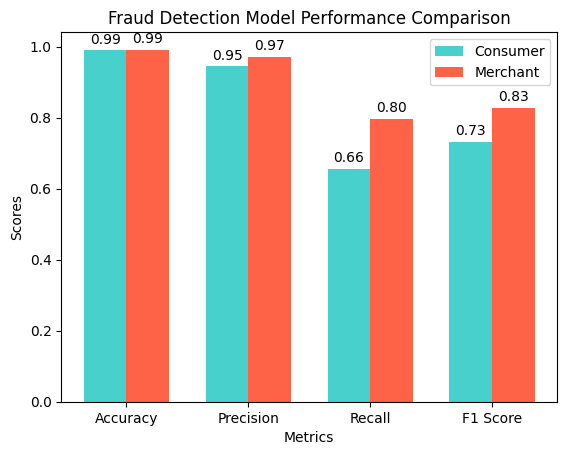

In [28]:
# Sample data
models = ['Consumer', 'Merchant']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
scores_model_a = [0.9896, 0.9452, 0.6564, 0.7322]
scores_model_b = [0.9913, 0.9716, 0.7971, 0.8279]

# Set the width of the bars
bar_width = 0.35

# Define the positions of the bars on the x-axis
x = range(len(metrics))

# Create subplots
fig, ax = plt.subplots()

# Create bar plots for the two models
bar1 = ax.bar(x, scores_model_a, width=bar_width, label='Consumer', color='mediumturquoise')
bar2 = ax.bar([i + bar_width for i in x], scores_model_b, width=bar_width, label='Merchant', color='tomato')

# Set the x-axis labels
ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(metrics)

# Set labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Fraud Detection Model Performance Comparison')

# Add numbers (labels) above the bars
for i, bar in enumerate(bar1):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{scores_model_a[i]:.2f}', ha='center', va='bottom')
for i, bar in enumerate(bar2):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{scores_model_b[i]:.2f}', ha='center', va='bottom')

ax.legend()

# Show and save the plot
plt.savefig('../plots/fraud_models_performance.png', bbox_inches='tight')
plt.show()